<a href="https://colab.research.google.com/github/quickgrid/CodeLab/blob/master/computer_vision/Fashion_MNIST_Keras_Functional_API_Ensemble_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO




```
*   Add multiple different architecture like resnet, mobilenet.
*   Add sequential api example with cross validation.
*   Use different metrics for imbalanced classification.
*   Save autoencoder model in savedmodel and hdf5 format.
*   Save and continue training from checkpoint.
*   Predict from loaded model and use slider for control.
*   Add variational auto encoder.
*   Add denoising with noisy mnist dataset.
*   Convert model to onnx and do inference with opencv.
*   Convert keras model to tflite with optimizations and infer with interpreter.
*   convert savedmodel to tensorflow frozen graph for opencv inference.
```















In [ ]:
## For using extra dataset not provided by regular keras

#!pip install extra-keras-datasets


## Some datasets like stl10, svhn, emnist and others can be imported

#from extra_keras_datasets import emnist

In [1]:
## all imports

seed_value = 0

import numpy as np
np.random.seed(seed_value)

import random
random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

from matplotlib import pyplot as plt

from IPython import display



In [2]:
BATCH_SIZE = 512

In [3]:
## load and normalize data

#(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#(x_train, y_train), (x_test, y_test) = emnist.load_data(type='balanced')

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()


x_train = x_train / 255.0
x_test = x_test / 255.0


# mean = np.mean(x_train)
# std = np.std(x_train)

# def standardize(x):
#     return (x-mean)/std

# standardize(x_train)
# standardize(x_test)

4423680/4422102 [==============================] - 0s 0us/step


array([[[-0.81025766, -0.81025766, -0.81025766, ..., -0.81025766,
         -0.81025766, -0.81025766],
        [-0.81025766, -0.81025766, -0.81025766, ..., -0.81025766,
         -0.81025766, -0.81025766],
        [-0.81025766, -0.81025766, -0.81025766, ..., -0.81025766,
         -0.81025766, -0.81025766],
        ...,
        [-0.81025766, -0.81025766, -0.81025766, ..., -0.81025766,
         -0.81025766, -0.81025766],
        [-0.81025766, -0.81025766, -0.81025766, ..., -0.81025766,
         -0.81025766, -0.81025766],
        [-0.81025766, -0.81025766, -0.81025766, ..., -0.81025766,
         -0.81025766, -0.81025766]],

       [[-0.81025766, -0.81025766, -0.81025766, ..., -0.81025766,
         -0.81025766, -0.81025766],
        [-0.81025766, -0.81025766, -0.81025766, ..., -0.81025766,
         -0.81025766, -0.81025766],
        [-0.81025766, -0.81025766, -0.81025766, ..., -0.81025766,
         -0.81025766, -0.81025766],
        ...,
        [-0.81025766, -0.81025766, -0.81025766, ..., -

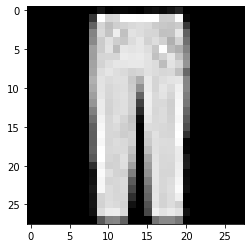

1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
trouser


In [4]:
## Show random example along with its label

random_example_number = random.randint(0,len(x_train))

plt.imshow(x_train[random_example_number], cmap='gray')
plt.show()


## label names from, https://github.com/zalandoresearch/fashion-mnist
labelNames = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]


label_index = y_train[random_example_number]
print(label_index)


y_train_ori = y_train
y_test_ori = y_test


y_test = to_categorical(y_test, len(labelNames))
y_train = to_categorical(y_train, len(labelNames))
print(y_train[random_example_number])

print(labelNames[label_index])

In [5]:
## Build a Multiple classification models for ensemble

## sample model 1

def get_model1():
  model_input = keras.Input(shape=(28, 28, 1), name="original_img")
  x = layers.Conv2D(16, 3, activation="relu")(model_input)
  x = layers.Conv2D(32, 3, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  x = layers.MaxPooling2D(2)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(32, 3, activation="relu")(x)
  x = layers.Conv2D(32, 3, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  x = layers.MaxPooling2D(3)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, activation="relu")(x)
  model_output = layers.Dense(10, activation="softmax")(x)

  model = keras.Model(inputs=model_input, outputs=model_output, name="fmnist_model1")

  return model

model1 = get_model1()
model1.summary()


Model: "fmnist_model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)      

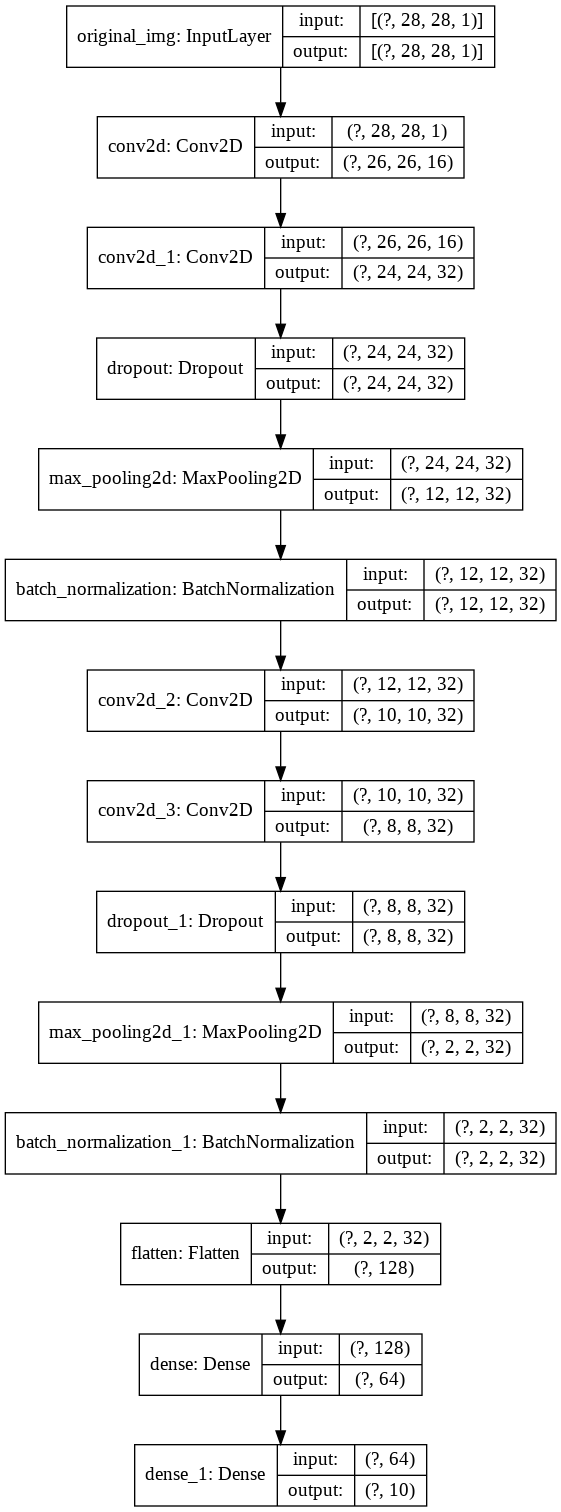

In [6]:
keras.utils.plot_model(model1, "model1.png", show_shapes=True)

In [7]:
## compile model, train and evaluate on test set

model1.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model1.fit(x_train, y_train, batch_size=512, epochs=10, validation_split=0.2)

test_scores = model1.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/10
94/94 [==============================] - 1s 16ms/step - loss: 1.7971 - accuracy: 0.6876 - val_loss: 1.7393 - val_accuracy: 0.7898
Epoch 2/10
94/94 [==============================] - 1s 12ms/step - loss: 1.6677 - accuracy: 0.8018 - val_loss: 1.7267 - val_accuracy: 0.7552
Epoch 3/10
94/94 [==============================] - 1s 12ms/step - loss: 1.6415 - accuracy: 0.8244 - val_loss: 1.7850 - val_accuracy: 0.6903
Epoch 4/10
94/94 [==============================] - 1s 13ms/step - loss: 1.6259 - accuracy: 0.8401 - val_loss: 1.7997 - val_accuracy: 0.6686
Epoch 5/10
94/94 [==============================] - 1s 12ms/step - loss: 1.6144 - accuracy: 0.8497 - val_loss: 1.8204 - val_accuracy: 0.6359
Epoch 6/10
94/94 [==============================] - 1s 12ms/step - loss: 1.6079 - accuracy: 0.8561 - val_loss: 1.7381 - val_accuracy: 0.7342
Epoch 7/10
94/94 [==============================] - 1s 12ms/step - loss: 1.6021 - accuracy: 0.8619 - val_loss: 1.7223 - val_accuracy: 0.7433
Epoch 8/10
94

[[242   0   9  14   0   1 722   0  12   0]
 [  0 948   0  13   0   0  36   0   3   0]
 [  0   0 455   3  13   0 522   0   7   0]
 [  1   3   7 809   0   0 180   0   0   0]
 [  0   0  19  23 286   0 668   0   4   0]
 [  0   1   0   3   0 886  14  35  42  19]
 [  9   0  21  13   2   0 949   0   6   0]
 [  0   0   0   0   0   5   5 940  11  39]
 [  0   0   1   2   0   2  33   0 962   0]
 [  0   0   0   1   0   4   2  32  11 950]]



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


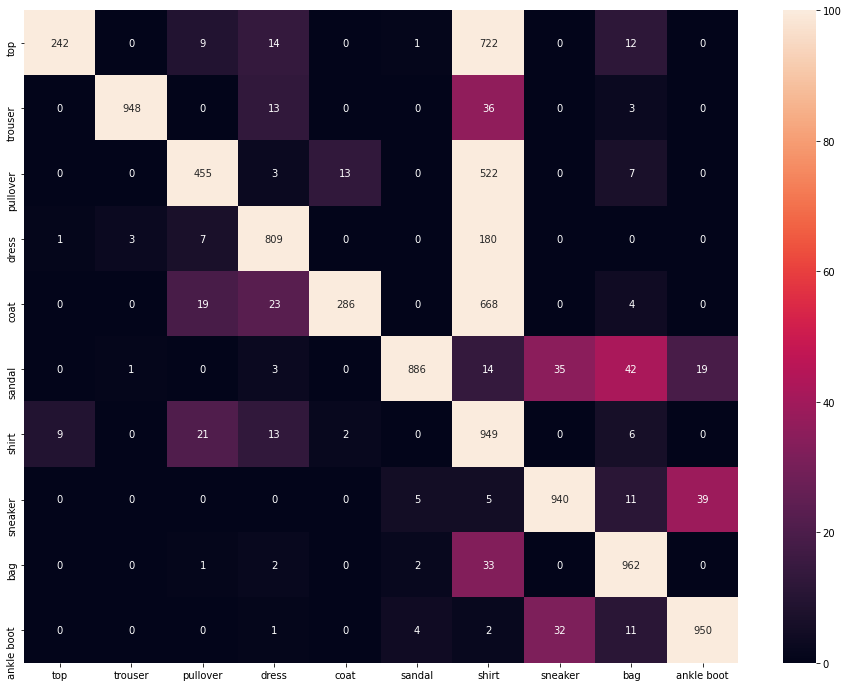

In [8]:
## Get and show confusion matrix

from sklearn.metrics import confusion_matrix

y_prob = model1.predict(x_test) 


y_classes = y_prob.argmax(axis=-1)
cm = confusion_matrix(y_true = y_test_ori, y_pred = y_classes)

#y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
#y_test = np.argmax(y_test, 1) # Decode labels
#cm = confusion_matrix(y_true = y_test, y_pred = y_pred)


print(cm)
print()



import seaborn as sn
plt.figure(figsize=(16, 12))
sn.heatmap(cm, annot=True, vmin=0, vmax=100, fmt='d', xticklabels=labelNames, yticklabels=labelNames)

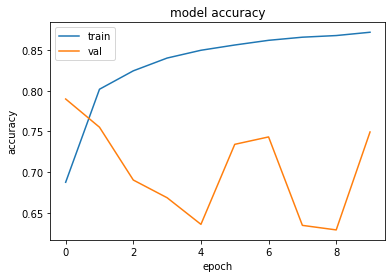

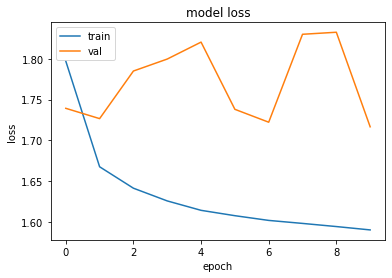

In [9]:
## plot metric

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## plot loss 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
## Build a Multiple classification models for ensemble

## sample model 2 a toy ResNet model


def get_model2():
  model_input = keras.Input(shape=(28, 28, 1), name="original_img")

  x = layers.Conv2D(32, 3, activation="relu")(model_input)
  x = layers.Conv2D(64, 3, activation="relu")(x)
  block_1_output = layers.MaxPooling2D(3)(x)

  x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  block_2_output = layers.add([x, block_1_output])

  x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  block_3_output = layers.add([x, block_2_output])

  x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  model_output = layers.Dense(10)(x)

  model = keras.Model(inputs=model_input, outputs=model_output, name="toy_resnet")

  return model

model2 = get_model2()
model2.summary()


Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_img (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 26, 26, 32)   320         original_img[0][0]               
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 24, 24, 64)   18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 64)     0           conv2d_5[0][0]                   
_________________________________________________________________________________________

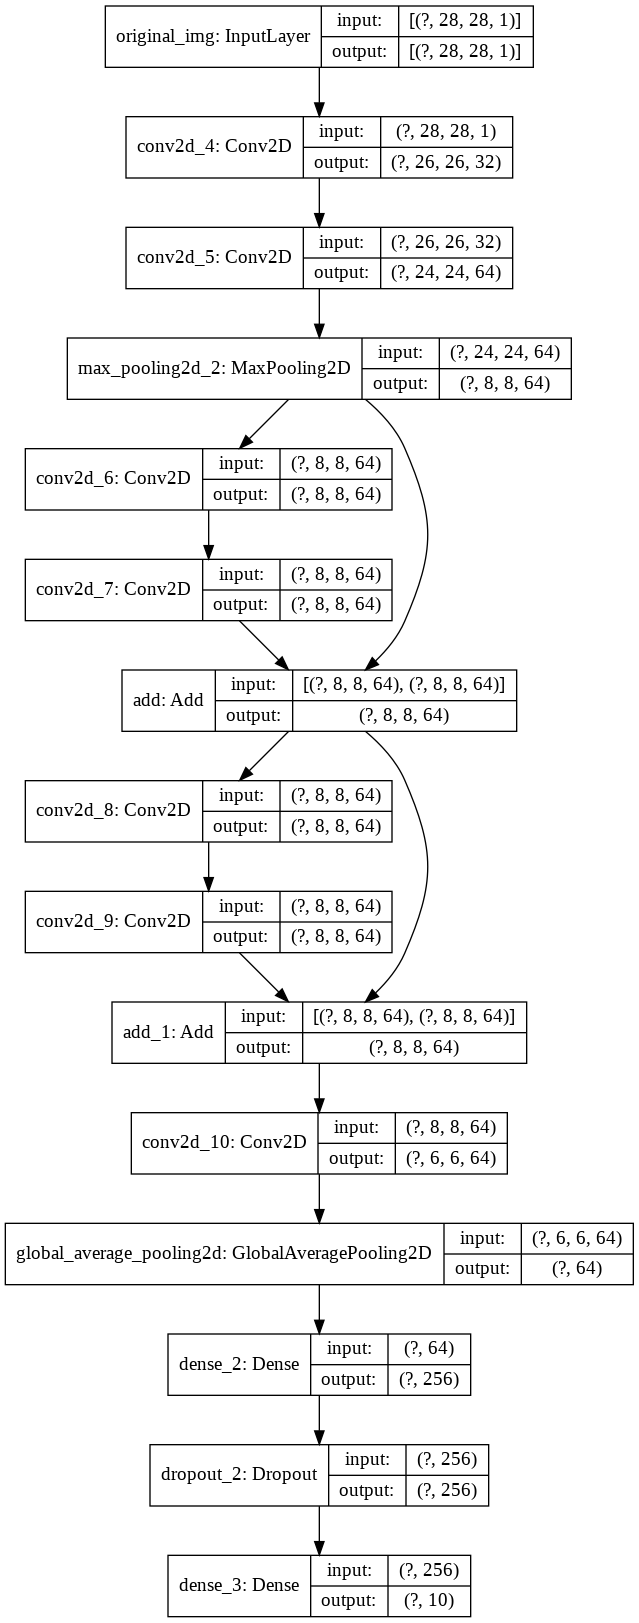

In [11]:
keras.utils.plot_model(model2, "toy_resnet.png", show_shapes=True)

In [12]:
## compile model, train and evaluate on test set

model2.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(1e-3),
    metrics=["accuracy"],
)

history = model2.fit(x_train, y_train, batch_size=512, epochs=10, validation_split=0.2)

test_scores = model2.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/10
94/94 [==============================] - 2s 23ms/step - loss: 1.6644 - accuracy: 0.5335 - val_loss: 0.6744 - val_accuracy: 0.7480
Epoch 2/10
94/94 [==============================] - 2s 20ms/step - loss: 0.6591 - accuracy: 0.7541 - val_loss: 0.6176 - val_accuracy: 0.7563
Epoch 3/10
94/94 [==============================] - 2s 20ms/step - loss: 0.5006 - accuracy: 0.8153 - val_loss: 0.4491 - val_accuracy: 0.8307
Epoch 4/10
94/94 [==============================] - 2s 20ms/step - loss: 0.4239 - accuracy: 0.8451 - val_loss: 0.5492 - val_accuracy: 0.7997
Epoch 5/10
94/94 [==============================] - 2s 20ms/step - loss: 0.3713 - accuracy: 0.8639 - val_loss: 0.3547 - val_accuracy: 0.8691
Epoch 6/10
94/94 [==============================] - 2s 20ms/step - loss: 0.3306 - accuracy: 0.8807 - val_loss: 0.2919 - val_accuracy: 0.8937
Epoch 7/10
94/94 [==============================] - 2s 20ms/step - loss: 0.3012 - accuracy: 0.8904 - val_loss: 0.3001 - val_accuracy: 0.8920
Epoch 8/10
94

[[915   2   6  11   0   0  41   0  25   0]
 [  3 978   1  14   0   0   2   0   2   0]
 [ 28   1 874  11  20   0  42   0  24   0]
 [ 29   4   6 923   7   0  25   0   6   0]
 [  0   4 122  56 715   0  82   0  21   0]
 [  0   0   0   0   0 984   0  11   0   5]
 [182   3  67  27  38   0 658   0  25   0]
 [  0   0   0   0   0   9   0 960   0  31]
 [  2   0   0   1   0   2   0   0 995   0]
 [  0   0   0   0   0   7   0  21   1 971]]



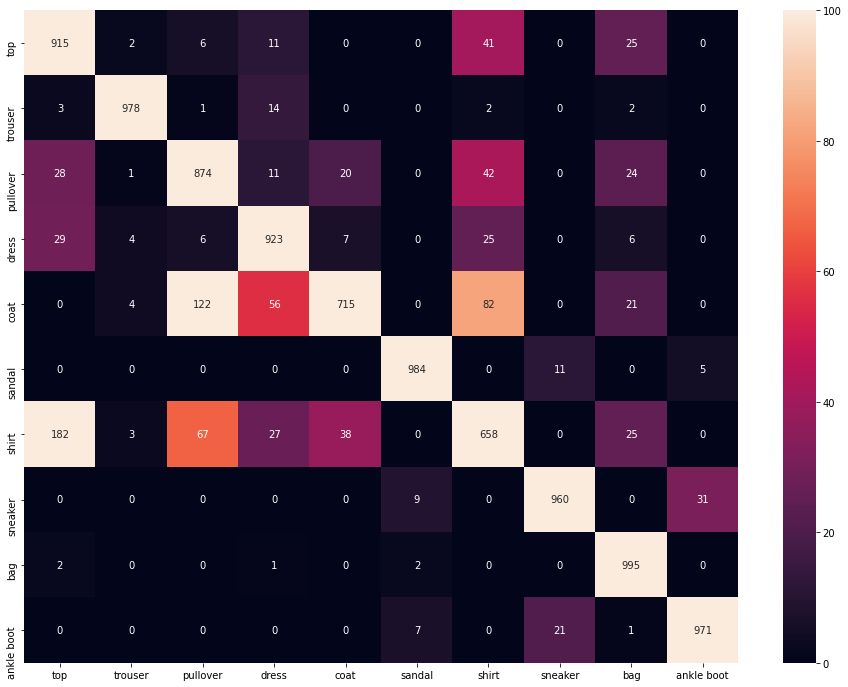

In [13]:
## Get and show confusion matrix

from sklearn.metrics import confusion_matrix

y_prob = model2.predict(x_test) 
y_classes = y_prob.argmax(axis=-1)

cm = confusion_matrix(y_true = y_test_ori, y_pred = y_classes)
print(cm)
print()



import seaborn as sn
plt.figure(figsize=(16, 12))
sn.heatmap(cm, annot=True, vmin=0, vmax=100, fmt='d', xticklabels=labelNames, yticklabels=labelNames)

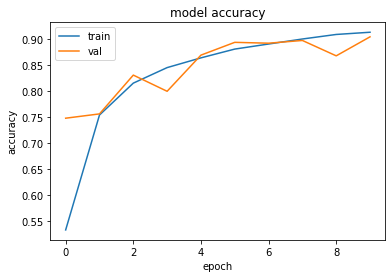

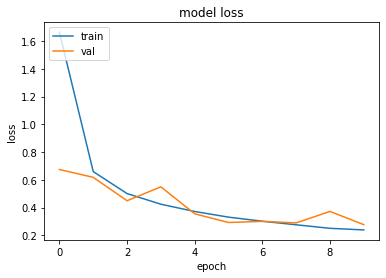

In [14]:
## plot metric

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## plot loss 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Ensemble

In [16]:
## ensemble multiple models

inputs = keras.Input(shape=(28, 28, 1))
y1 = model1(inputs)
y2 = model2(inputs)
outputs = layers.average([y1, y2])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

ensemble_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
fmnist_model1 (Functional)      (None, 10)           32458       input_1[0][0]                    
__________________________________________________________________________________________________
toy_resnet (Functional)         (None, 10)           222666      input_1[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 10)           0           fmnist_model1[0][0]              
                                                                 toy_resnet[0][0]      

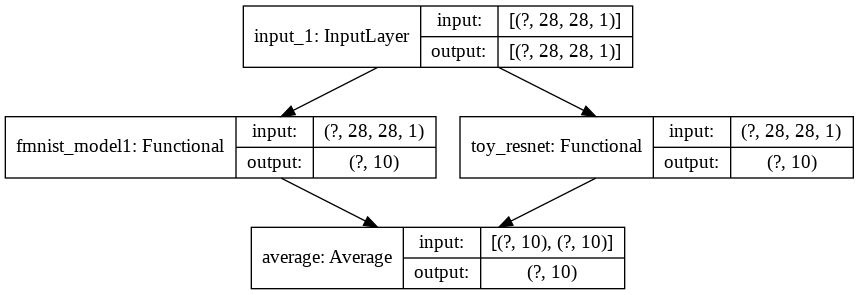

In [17]:
keras.utils.plot_model(ensemble_model, "ensemble_model.png", show_shapes=True)

In [18]:
## compile model, train and evaluate on test set

ensemble_model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history = ensemble_model.fit(x_train, y_train, batch_size=512, epochs=10, validation_split=0.2)

test_scores = ensemble_model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/10
94/94 [==============================] - 3s 32ms/step - loss: 0.2045 - accuracy: 0.9249 - val_loss: 0.2285 - val_accuracy: 0.9196
Epoch 2/10
94/94 [==============================] - 3s 29ms/step - loss: 0.1798 - accuracy: 0.9349 - val_loss: 0.2202 - val_accuracy: 0.9197
Epoch 3/10
94/94 [==============================] - 3s 28ms/step - loss: 0.1667 - accuracy: 0.9394 - val_loss: 0.2303 - val_accuracy: 0.9192
Epoch 4/10
94/94 [==============================] - 3s 28ms/step - loss: 0.1520 - accuracy: 0.9444 - val_loss: 0.2218 - val_accuracy: 0.9233
Epoch 5/10
94/94 [==============================] - 3s 28ms/step - loss: 0.1407 - accuracy: 0.9486 - val_loss: 0.2131 - val_accuracy: 0.9247
Epoch 6/10
94/94 [==============================] - 3s 28ms/step - loss: 0.1221 - accuracy: 0.9559 - val_loss: 0.2271 - val_accuracy: 0.9237
Epoch 7/10
94/94 [==============================] - 3s 28ms/step - loss: 0.1125 - accuracy: 0.9586 - val_loss: 0.2204 - val_accuracy: 0.9265
Epoch 8/10
94

[[864   2  35  11   4   0  77   0   7   0]
 [  0 984   1  11   1   0   3   0   0   0]
 [  7   2 923   4  31   0  33   0   0   0]
 [  9   9  20 895  34   0  33   0   0   0]
 [  0   1  48   7 906   0  38   0   0   0]
 [  0   0   0   0   0 979   0  19   0   2]
 [ 98   3  78  12  86   0 719   0   4   0]
 [  0   0   0   0   0   4   0 986   0  10]
 [  3   0   6   0   2   2   3   0 983   1]
 [  0   2   0   0   0  10   0  35   0 953]]



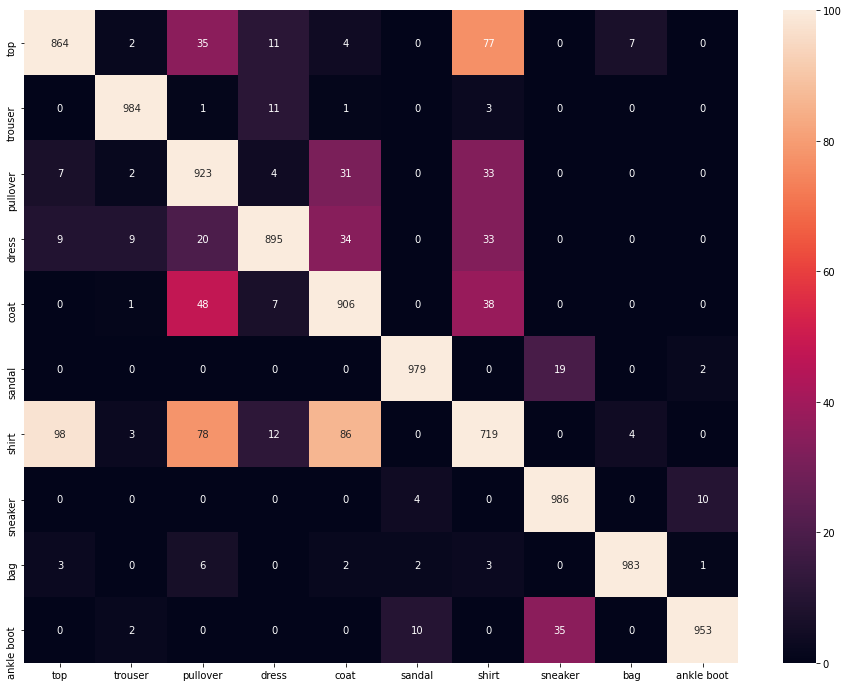

In [19]:
## Get and show confusion matrix

from sklearn.metrics import confusion_matrix

y_prob = ensemble_model.predict(x_test) 
y_classes = y_prob.argmax(axis=-1)

cm = confusion_matrix(y_true = y_test_ori, y_pred = y_classes)
print(cm)
print()



import seaborn as sn
plt.figure(figsize=(16, 12))
sn.heatmap(cm, annot=True, vmin=0, vmax=100, fmt='d', xticklabels=labelNames, yticklabels=labelNames)

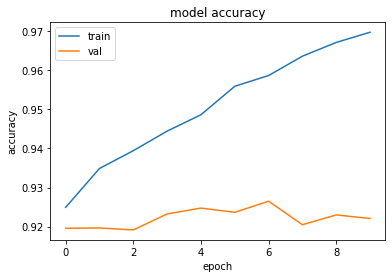

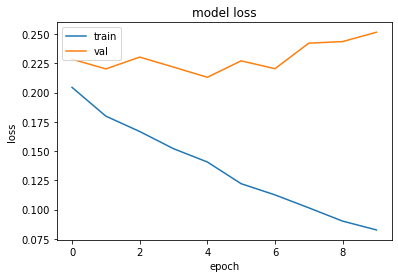

In [20]:
## plot metric

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## plot loss 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Auto Encoder

In [37]:
## Used if standardize function is used above

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

In [38]:
## define the layers and create models with functional api

## Encoder
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()


## Decoder
decoder_input = keras.Input(shape=(16, ), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()


## Auto Encoder
autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
autoencoder_output = decoder(encoded_img)
 
autoencoder = keras.Model(autoencoder_input, autoencoder_output, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

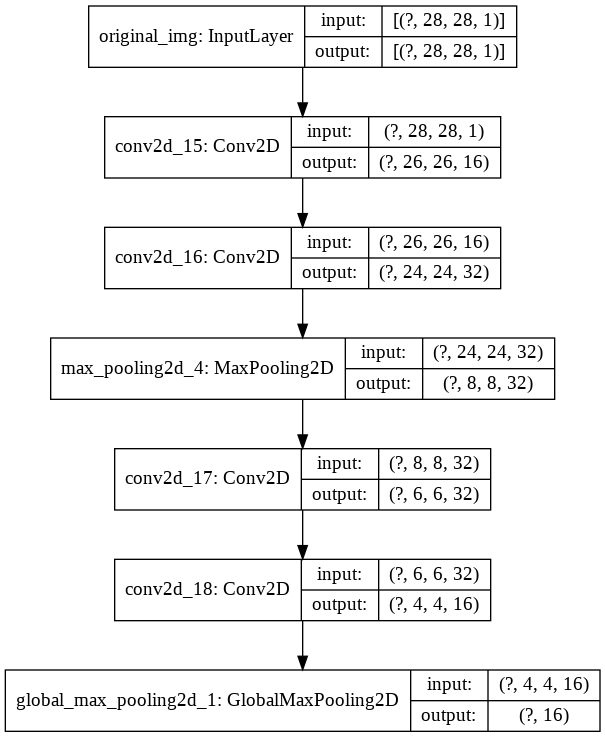

In [39]:
keras.utils.plot_model(encoder, "encoder.png", show_shapes=True)

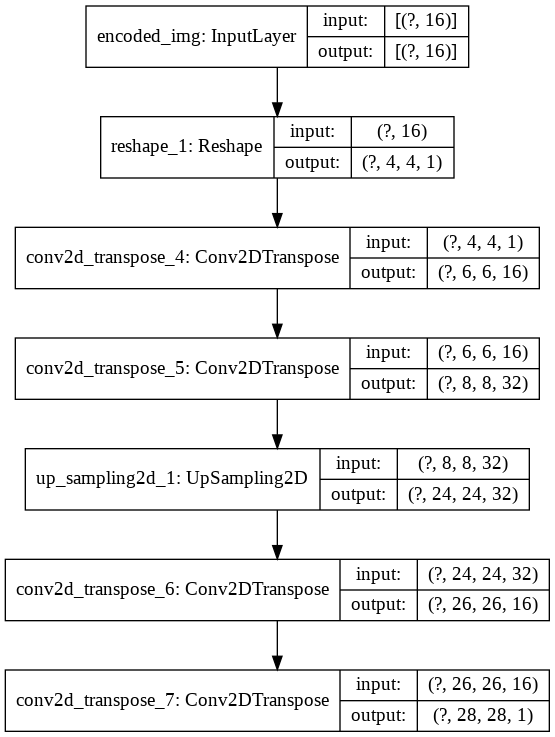

In [40]:
keras.utils.plot_model(decoder, "decoder.png", show_shapes=True)

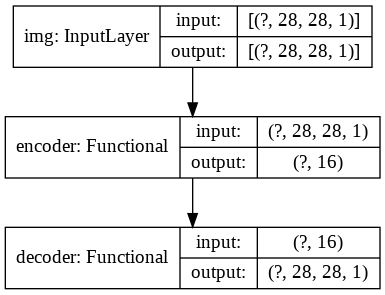

In [41]:
keras.utils.plot_model(autoencoder, "autoencoder.png", show_shapes=True)

In [42]:
autoencoder.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

## Both are same data since autoencoder has same input and output dimension
history = autoencoder.fit(x_train, x_train, batch_size=BATCH_SIZE, epochs=10, validation_split=0.2)

test_scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/10
94/94 [==============================] - 2s 19ms/step - loss: 0.5417 - accuracy: 0.4900 - val_loss: 0.4570 - val_accuracy: 0.4853
Epoch 2/10
94/94 [==============================] - 2s 16ms/step - loss: 0.4375 - accuracy: 0.4909 - val_loss: 0.4175 - val_accuracy: 0.4910
Epoch 3/10
94/94 [==============================] - 2s 16ms/step - loss: 0.4040 - accuracy: 0.4959 - val_loss: 0.3962 - val_accuracy: 0.4934
Epoch 4/10
94/94 [==============================] - 1s 16ms/step - loss: 0.3900 - accuracy: 0.4977 - val_loss: 0.3888 - val_accuracy: 0.4965
Epoch 5/10
94/94 [==============================] - 1s 16ms/step - loss: 0.3782 - accuracy: 0.4985 - val_loss: 0.3836 - val_accuracy: 0.4941
Epoch 6/10
94/94 [==============================] - 2s 16ms/step - loss: 0.3703 - accuracy: 0.4992 - val_loss: 0.3684 - val_accuracy: 0.4958
Epoch 7/10
94/94 [==============================] - 1s 16ms/step - loss: 0.3629 - accuracy: 0.4997 - val_loss: 0.3617 - val_accuracy: 0.4977
Epoch 8/10
94